[View in Colaboratory](https://colab.research.google.com/github/saitota/ProgrammingKnock100/blob/master/Chapter04_Q30_Q39.ipynb)

# :muscle: 前書き
詳細は[第1章](https://qiita.com/saitotak/items/73852ecb7cc4b10b42a5)参照、引き続き言語処理100本ノックの第3章を回答していきます。本章では TBD


# :muscle: 第4章: 形態素解析
> 夏目漱石の小説『吾輩は猫である』の文章（[neko.txt](http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt)）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．
> なお，問題37, 38, 39は[matplotlib](http://matplotlib.org/)もしくは[Gnuplot](http://www.gnuplot.info/)を用いるとよい．

UTF-8,LF の1万行程度の日本語プレーンテキストでした。形態素解析と統計のライブラリを存分に使うことになりそうな感じです。

```text:neko.txt
一

　吾輩は猫である。
名前はまだ無い。

　どこで生れたかとんと見当がつかぬ。
何でも薄暗いじめじめした所でニャーニャー泣いていた事だけは記憶している。
（以下略）
```

## ⚾ 30. 形態素解析結果の読み込み
> 形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．


## 下準備として
- ファイルダウンロード
- janomeのインストール

In [2]:
import urllib.request
urllib.request.urlretrieve('http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt','./neko.txt')


('./neko.txt', <http.client.HTTPMessage at 0x7f3dd09b0080>)

In [3]:
!pip install janome

### 解0-1 janomeによる形態素解析と、neko.txt.janome のテキスト作成（おそい）
- MeCab ではなく janome をインストールします、なぜならインストールが簡単だったから。
- `janome.tokenizer` を使って形態素解析します
    - [janome package — janome.tokenizer](http://mocobeta.github.io/janome/api/janome.html#module-janome.tokenizer)
- やたら遅かったので、開始・終了 時間を計測するコードを入れました
- 実測：42sec


In [4]:
from janome.tokenizer import Tokenizer
import janome
import datetime

print('start:' + str(datetime.datetime.now()))

t = Tokenizer()

# WriteのたびにOpen
with open ('./neko.txt','r',encoding='utf-8') as file_temp:
    for line in file_temp:
        # 形態素解析して保存
        for token in t.tokenize(line, stream=True):
            with open ('./neko.txt.janome-01','a',encoding='utf-8') as file_janome:
                    file_janome.write(str(token) + '\n')

print('end:' + str(datetime.datetime.now()))

'''
一	名詞,数,*,*,*,*,一,イチ,イチ
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
（以下略）
'''


start:2018-05-28 11:47:24.653929
end:2018-05-28 11:48:10.635433


'\n一\t名詞,数,*,*,*,*,一,イチ,イチ\n吾輩\t名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ\nは\t助詞,係助詞,*,*,*,*,は,ハ,ワ\n猫\t名詞,一般,*,*,*,*,猫,ネコ,ネコ\nで\t助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ\nある\t助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル\n。\t記号,句点,*,*,*,*,。,。,。\n名前\t名詞,一般,*,*,*,*,名前,ナマエ,ナマエ\n（以下略）\n'

### 解0-2 高速化
- メモリ枯渇を鑑み 形態素解析→write を繰り返すようにしてみましたが、やたらと時間がかかったため、一括で書き込むようにして高速化を図ります
- 実測：29sec

In [5]:
print('start:' + str(datetime.datetime.now()))

t = Tokenizer()

# Openしてから
with open ('./neko.txt','r',encoding='utf-8') as file_temp , open ('./neko.txt.janome-02','a',encoding='utf-8') as file_janome:
    for line in file_temp:
        # 形態素解析して保存
        for x in t.tokenize(line, stream=True):
            file_janome.write(str(x) + '\n') 
            

print('end:' + str(datetime.datetime.now()))

start:2018-05-28 11:48:12.501624
end:2018-05-28 11:48:44.072151


### 解0-3 さらに高速化
- それでも遅い気がしたので、書き込み部分をリスト内包表記にしました、多少早くなった
- 実測：27sec


In [6]:
print('start:' + str(datetime.datetime.now()))

t = Tokenizer()

# 一部リスト内包表記
with open ('./neko.txt','r',encoding='utf-8') as file_temp , open ('./neko.txt.janome-03','a',encoding='utf-8') as file_janome:
    for line in file_temp:
        # 形態素解析して保存
        [file_janome.write(str(x) + '\n') for x in t.tokenize(line, stream=True)]
            

print('end:' + str(datetime.datetime.now()))

start:2018-05-28 11:48:44.825142
end:2018-05-28 11:49:15.808801


### 解0-4 さらに高速化・・・失敗
- 読みにくいですがぜんぶリスト内包表記にしました
- 実測：88sec
  - 遅くなった何故。。。

In [7]:
print('start:' + str(datetime.datetime.now()))

t = Tokenizer()

# リスト内包表記
with open ('./neko.txt','r',encoding='utf-8') as file_temp , open ('./neko.txt.janome-04','a',encoding='utf-8') as file_janome:
    [
        [
            file_janome.write(str(x) + '\n')
            for x in t.tokenize(y, stream=True)
        ]
        for y in file_temp
    ]

print('end:' + str(datetime.datetime.now()))

start:2018-05-28 11:49:16.429262
end:2018-05-28 11:49:47.734940


### 解1 neko.txt.janome のテキスト作成
-  形態素はタブ区切り、品詞等の分類はカンマ区切りなので成型します

In [62]:
with open ('./neko.txt.janome-04','r',encoding='utf-8') as file_temp:
    text = file_temp.readlines()

lst_janome=[]
for line in text:
    lst_janome.append(
        { 'surface': line.split('\t')[0], # 表層形
          'pos'    : line.split('\t')[1].split(',')[0], # 品詞
          'pos1'   : line.split('\t')[1].split(',')[1], # 品詞細分類1
          'base'   : line.split('\t')[1].split(',')[6]   # 基本形
        })

print(lst_janome[:10:]) # 10件表示
  

[{'surface': '一', 'pos': '名詞', 'pos1': '数', 'base': '一'}, {'surface': '吾輩', 'pos': '名詞', 'pos1': '代名詞', 'base': '吾輩'}, {'surface': 'は', 'pos': '助詞', 'pos1': '係助詞', 'base': 'は'}, {'surface': '猫', 'pos': '名詞', 'pos1': '一般', 'base': '猫'}, {'surface': 'で', 'pos': '助動詞', 'pos1': '*', 'base': 'だ'}, {'surface': 'ある', 'pos': '助動詞', 'pos1': '*', 'base': 'ある'}, {'surface': '。', 'pos': '記号', 'pos1': '句点', 'base': '。'}, {'surface': '名前', 'pos': '名詞', 'pos1': '一般', 'base': '名前'}, {'surface': 'は', 'pos': '助詞', 'pos1': '係助詞', 'base': 'は'}, {'surface': 'まだ', 'pos': '副詞', 'pos1': '助詞類接続', 'base': 'まだ'}]



## ⚾ 31. 動詞
> 動詞の表層形をすべて抽出せよ．

## 解1 普通にループ

In [63]:
lst_res = []
for janome in lst_janome:
    if janome.get('pos') == '動詞':
        lst_res.append(janome.get('surface'))

print(lst_res[:10:]) # 10件表示 

['生れ', 'つか', 'し', '泣い', 'し', 'いる', '始め', '見', '聞く', '捕え']


## 解2. 内容表記と重複排除
- このくらいのループであればリスト内包表記のほうがいいかも
- `set()` による重複排除

In [64]:
lst_res = list(set([x.get('surface') for x in lst_janome if x.get('pos') == '動詞']))
print(lst_res[:10:]) # 10件表示

['求め', 'はめ', '出せ', '崩す', '蒔い', '罵る', '溺れ', '及び', 'つかまっ', '驚き']



## ⚾ 32. 動詞の原形
> 動詞の原形をすべて抽出せよ．


## 解1. 内包表記
- 原型=基本形（base）のようです

In [0]:
st_res = list(set([x.get('base') for x in lst_janome if x.get('pos') == '動詞']))
print(lst_res[:10:]) # 10件表示

## ⚾ 33. サ変名詞
> サ変接続の名詞をすべて抽出せよ．

## 解1. 内包表記
- 品詞細分類1がサ変接続のものを探します

In [60]:
lst_res = list(set([x.get('base') for x in lst_janome if x.get('pos1') == 'サ変接続']))
print(lst_res[:10:]) # 10件表示

['外出', '道楽', '連署', '丹精', '伏', '予期', '進歩', '演習', '算段', '渉猟']


## ⚾ 34. 「AのB」
> 2つの名詞が「の」で連結されている名詞句を抽出せよ．

## 解1. 普通にループ
- 名詞 の 名詞 を探します

In [59]:
lst_res = []
for i,janome in enumerate(lst_janome):
    if janome.get('base') == 'の':
        if (lst_janome[i-1].get('pos') == '名詞') and (lst_janome[i+1].get('pos') == '名詞'):
          lst_res.append(lst_janome[i-1].get('base') + janome.get('base') + lst_janome[i+1].get('base'))

print(lst_res[:10:]) # 10件表示

['彼の掌', '掌の上', '書生の顔', 'はずの顔', '顔の真中', '穴の中', '書生の掌', '掌の裏', '何の事', '肝心の母親']


## ⚾ 35. 名詞の連接
> 名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．


## 解1. 普通にループ
- 名詞 の繰り返しを探します
- 名詞×5以上 を求めてみました

In [58]:
lst_res = []
lst_tmp = []
for janome in lst_janome:
    if janome.get('pos') == '名詞':
         lst_tmp.append(janome.get('surface'))
    else:
        lst_tmp.clear()
    if(len(lst_tmp) > 4): #ほんとは1が条件
        lst_res.append(''.join(lst_tmp))

print(lst_res[:10:]) # 10件表示

['壱円五十銭', '一杯一杯一', '一杯一杯一杯', '三毛子さん三毛', '三毛子さん三毛子', '三毛子さん三毛子さん', '吾等猫属間', '一切れ二銭三', '一切れ二銭三厘', '鳥部教授歓迎会']


## ⚾ 36. 単語の出現頻度
> 文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．


## 解1. collections型
- `collections` の `most_common([n])`ｄ集計
    - [8.3. collections](https://docs.python.jp/3/library/collections.html#collections.Counter.most_common)
- Pandasとか使うのかと思った

In [57]:
import collections

lst_tmp = []
for janome in lst_janome:
    lst_tmp.append(janome.get('surface'))

cnt = collections.Counter(lst_tmp)
lst_commons = cnt.most_common()

print(lst_commons[:10:]) # 10件表示

  

[('の', 36776), ('。', 29944), ('て', 27460), ('、', 27088), ('は', 25680), ('に', 24956), ('を', 24268), ('と', 22020), ('が', 21344), ('た', 15952)]



## ⚾ 37. 頻度上位10語
> 出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．




## 解1. matplotlib.pyplot でグラフ表示
- `matplotlib.pyplot`  でグラフ化する
    - [matplotlib.pyplot — Matplotlib 2.2.2 documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot)
- インストールから必要だと思ったけれど。colab環境には既に入っていた
- 日本語フォント `fonts-ipafont-gothic` をインストール
- フォント指定には `matplotlib.font_manager` を使用

In [16]:
!pip install matplotlib
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-17ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


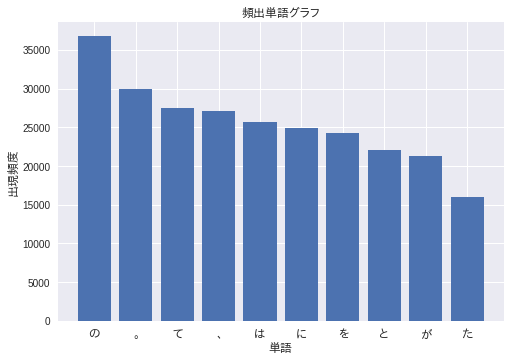

In [17]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

lst_words = [] 
lst_count = [] 

for lst_common in lst_commons[:10:]:
  lst_words.append(lst_common[0])
  lst_count.append(lst_common[1])

# 日本語フォント
fp = FontProperties(fname='/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf') 

# ラベル設定
plt.title('頻出単語グラフ', fontproperties=fp)
plt.xlabel('単語', fontproperties=fp) # 横軸
plt.ylabel('出現頻度', fontproperties=fp) # 縦軸

#データプロット
plt.xticks(range(10),lst_words,fontproperties=fp) # 横軸
plt.bar(range(10),lst_count) # 縦軸
plt.show() # 表示


## ⚾ 38. ヒストグラム
> 単語の出現頻度のヒストグラム（横軸に出現頻度，縦軸に出現頻度をとる単語の種類数を棒グラフで表したもの）を描け．

### 解1. matplotlib.hist でグラフ表示
- 手集計してグラフ表示します
- ラベルがグチャってなる…

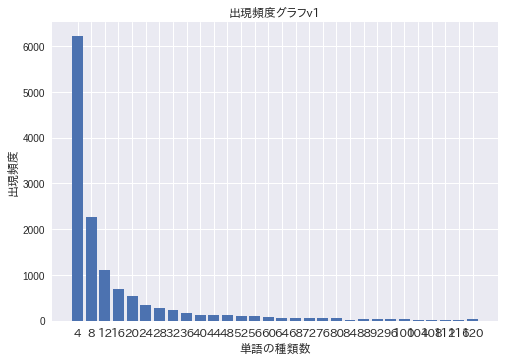

In [51]:
lst_cnt = {}
lst_cnt2 = {}

for lst_common in lst_commons:
    lst_cnt[lst_common[1]] = lst_cnt.get(lst_common[1],0) + 1

lst_cnt2 =dict(sorted(lst_cnt.items(), key=lambda x: x[0])) #逆順ソート

# 日本語フォント
fp = FontProperties(fname='/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf') 

# ラベル設定
plt.title('出現頻度グラフv1', fontproperties=fp)
plt.xlabel('単語の種類数', fontproperties=fp) # 横軸
plt.ylabel('出現頻度', fontproperties=fp) # 縦軸

v = [int(v) for k,v in lst_cnt2.items()] # 縦軸
k = [int(k) for k,v in lst_cnt2.items()] # 横軸

#データプロット
plt.xticks(range(30) ,k[:30:],fontproperties=fp) # 横軸
plt.bar(range(30),v[:30:])# 縦軸

plt.show() # 表示

## 解2. matplotlib.hist でグラフ表示
- `xticks` ではなく `hist` を使用すると、ヒストグラムを計算して描画してくれます
  - [matplotlib.pyplot.hist — Matplotlib 2.2.2 documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html)

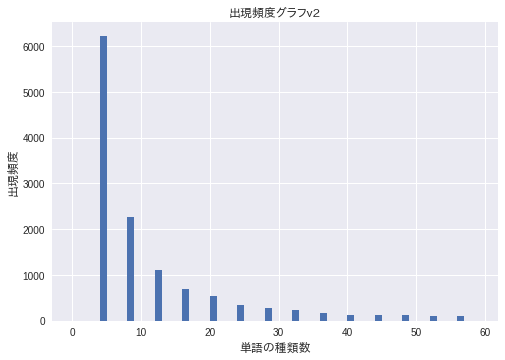

In [65]:
# 日本語フォント
fp = FontProperties(fname='/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf') 

# ラベル設定
plt.title('出現頻度グラフv2', fontproperties=fp)
plt.xlabel('単語の種類数', fontproperties=fp) # 横軸
plt.ylabel('出現頻度', fontproperties=fp) # 縦軸

lst_cnt = list(zip(*lst_commons))[1]

plt.hist(lst_cnt,
    range(60)) 

plt.show() # 表示



## ⚾ 39. Zipfの法則
> 単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．
